# Amazon Reviews Based Recommender
### Reference: https://www.kaggle.com/saurav9786/recommender-system-using-amazon-reviews

In [2]:
### Imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# import math
# import json
# import time
# import matplotlib.pyplot as plt
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import NearestNeighbors
# from sklearn.externals import joblib
# import scipy.sparse
# from scipy.sparse import csr_matrix
# from scipy.sparse.linalg import svds
# import warnings; warnings.simplefilter('ignore')
# %matplotlib inline

In [3]:
electronic_ratings = pd.read_csv('~/Documents/Datasets/AmazonReviews/ratings_Electronics.csv', names=['userId', 'productId','Rating','timestamp'])
electronic_ratings.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
electronic_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [5]:
electronic_ratings.shape

(7824482, 4)

In [6]:
electronic_ratings['Rating'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [7]:
#Min and Max Ratings
print('Max Rating is: %d' %(electronic_ratings['Rating'].max()))
print('Min Rating is: %d' %(electronic_ratings['Rating'].min()))

Max Rating is: 5
Min Rating is: 1


In [8]:
electronic_ratings.isnull().sum()

userId       0
productId    0
Rating       0
timestamp    0
dtype: int64

/home/sudeep/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/sudeep/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


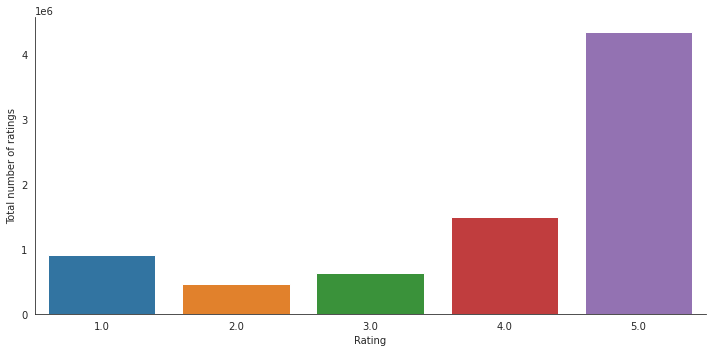

In [9]:
#plotting the ratings
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=electronic_ratings, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [10]:
print('Data Overview')
print('-'*50)
print('Total number of ratings: ', electronic_ratings.shape)
print('\nTotal number of unique products: ', len(np.unique(electronic_ratings['productId'])))
print('Total number of unique users: ', len(np.unique(electronic_ratings['userId'])))


Data Overview
--------------------------------------------------
Total number of ratings:  (7824482, 4)

Total number of unique products:  476002
Total number of unique users:  4201696


In [11]:
# number of items rated per user
no_items_rated_per_user = electronic_ratings.groupby(by='userId')['Rating'].count().sort_values(ascending= False)
no_items_rated_per_user.head()

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: Rating, dtype: int64

In [58]:
# finding the most popular products
new_df = electronic_ratings.groupby(by='productId').filter(lambda x: x['Rating'].count() >= 500)
new_df.head()

,userId,productId,Rating,timestamp
183,A1BKC6B7YHYTVV,0972683275,4.0,1405382400
184,AWVFSIB42LHKJ,0972683275,4.0,1405209600
185,A36MQBNADRH8YY,0972683275,5.0,1405641600
186,A3SRXMPLAEZ6DP,0972683275,4.0,1405987200
187,A20XXTXWF2TCPY,0972683275,5.0,1405123200


In [27]:
new_df.shape

(2203944, 4)

In [28]:
# average rating per popular product
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0043WJRRS    4.881369
B0029N3U8K    4.869301
B004Y1AYAC    4.854442
B003FVVMS0    4.853412
B001W26TIW    4.843537
Name: Rating, dtype: float64

In [29]:
ratings_mean_count = pd.DataFrame(new_df.groupby(by='productId')['Rating'].mean())
ratings_mean_count.head()

,Rating
productId,
0972683275,4.470980
B00001P4XA,3.832470
B00001P4ZH,4.456386
B00001WRSJ,4.609079
B00004SABB,4.011650


In [30]:
ratings_mean_count['ratings_count'] = pd.DataFrame(new_df.groupby(by='productId')['Rating'].count())
ratings_mean_count.head()

,Rating,ratings_count
productId,,
0972683275,4.470980,1051
B00001P4XA,3.832470,579
B00001P4ZH,4.456386,2075
B00001WRSJ,4.609079,1586
B00004SABB,4.011650,1030


## Colaborative Filtering

In [40]:
## imports

from surprise import KNNWithMeans, Dataset, accuracy, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

In [32]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(new_df.drop(['timestamp'], axis=1), reader)


In [34]:
# splitting the dataset
trainset, testset = train_test_split(data, test_size=0.5,random_state=10)

In [35]:
# use user_based hyperparameter to switch between user based CF and item based CF. Here we intend to perform item based
# thus setting it false. Using similarity measure of pearson_baseline

algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})


In [24]:
new_df.shape
#electronic_ratings.shape

(5374313, 4)

In [36]:
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [37]:
test_pred = algo.test(testset)
print('RMSE Accuracy of test prediction')
accuracy.rmse(test_pred, verbose=True)

RMSE Accuracy of test prediction
RMSE: 1.2873


1.287258909513765

In [42]:
# Using SVD
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2346  1.2333  1.2309  1.2337  1.2338  1.2332  0.0013  
MAE (testset)     0.9516  0.9510  0.9488  0.9509  0.9506  0.9506  0.0009  
Fit time          293.31  296.13  296.14  293.65  292.83  294.41  1.43    
Test time         7.81    5.42    5.46    7.52    5.43    6.33    1.10    


{'test_rmse': array([1.23458479, 1.23328666, 1.23086116, 1.23366154, 1.23375698]),
 'test_mae': array([0.95158185, 0.95099121, 0.94881905, 0.95086879, 0.95063554]),
 'fit_time': (293.30934023857117,
  296.1294949054718,
  296.1436619758606,
  293.6508255004883,
  292.8313639163971),
 'test_time': (7.812835454940796,
  5.42353081703186,
  5.461823463439941,
  7.518765449523926,
  5.428802967071533)}

In [44]:
algo.fit(trainset)

In [47]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2203944 entries, 183 to 7795934
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 84.1+ MB


In [48]:
algo.predict('A36MQBNADRH8YY', '0972683275', r_ui=4, verbose=True)

user: A36MQBNADRH8YY item: 0972683275 r_ui = 4.00   est = 4.38   {'was_impossible': False}


Prediction(uid='A36MQBNADRH8YY', iid='0972683275', r_ui=4, est=4.380598621783171, details={'was_impossible': False})

In [59]:
predictions = algo.test(testset)
accuracy.rmse(predictions, verbose=True)

RMSE: 1.2294


1.2294097602071337